# SDG Multilingual Media Narratives — Notebook 03: Analysis (Trends, Topics, Networks)

This notebook demonstrates:
- SDG volume trends over time
- SDG distribution by language/country
- baseline topic modeling (LDA) on snippets
- simple co-occurrence network (SDG ↔ country)

These are baseline analyses aligned with the plan described in your document. fileciteturn0file0


In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sdg_helpers import ensure_dir

# Try to import project parquet helper; fallback to pyarrow directly.
try:
    from sdg_parquet import read_parquet
except Exception:
    import pyarrow.parquet as pq
    def read_parquet(path: str) -> pd.DataFrame:
        return pq.read_table(path).to_pandas()

PROJECT_DIR = os.path.abspath('.')
PROCESSED_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
ensure_dir(FIG_DIR)

long = read_parquet(os.path.join(PROCESSED_DIR, 'articles_sdg_long.parquet'))
tagged = read_parquet(os.path.join(PROCESSED_DIR, 'articles_tagged.parquet'))
long.shape, tagged.shape


((182720, 14), (158648, 14))

In [22]:
long['seendate_utc'] = pd.to_datetime(long['seendate_utc'], utc=True, errors='coerce')
long['month'] = long['seendate_utc'].dt.to_period('M').astype(str)
long[['month','sdg']].head()


/var/folders/48/64q17bwx0vj129s9_p6bxt400000gn/T/ipykernel_18246/1542790594.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  long['month'] = long['seendate_utc'].dt.to_period('M').astype(str)


,month,sdg
0,2024-01,SDG17_Partnerships
1,2024-01,SDG17_Partnerships
2,2024-01,SDG17_Partnerships
3,2024-01,SDG3_Good_Health
4,2024-01,SDG17_Partnerships


## 1) Trend lines: SDG mentions per month


In [23]:
pivot = (long.groupby(['month','sdg']).size()
         .reset_index(name='count')
         .pivot(index='month', columns='sdg', values='count')
         .fillna(0)
        )
pivot.tail()


sdg,SDG10_Reduced_Inequalities,SDG11_Sustainable_Cities,SDG12_Responsible_Consumption,SDG13_Climate_Action,SDG14_Life_Below_Water,SDG15_Life_On_Land,SDG16_Peace_Justice,SDG17_Partnerships,SDG1_No_Poverty,SDG2_Zero_Hunger,SDG3_Good_Health,SDG4_Quality_Education,SDG5_Gender_Equality,SDG6_Clean_Water,SDG7_Clean_Energy,SDG8_Decent_Work,SDG9_Industry_Innovation
month,,,,,,,,,,,,,,,,,
2025-09,59.0,140.0,30.0,186.0,86.0,134.0,75.0,4086.0,136.0,30.0,855.0,230.0,110.0,142.0,217.0,133.0,136.0
2025-10,65.0,146.0,56.0,195.0,59.0,175.0,74.0,5073.0,204.0,56.0,761.0,246.0,183.0,130.0,364.0,200.0,191.0
2025-11,71.0,140.0,39.0,266.0,75.0,175.0,98.0,4783.0,162.0,37.0,711.0,215.0,196.0,127.0,170.0,213.0,184.0
2025-12,62.0,121.0,40.0,175.0,45.0,149.0,85.0,4319.0,251.0,24.0,845.0,185.0,122.0,148.0,233.0,199.0,193.0
2026-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_total_mentions_per_month.png'

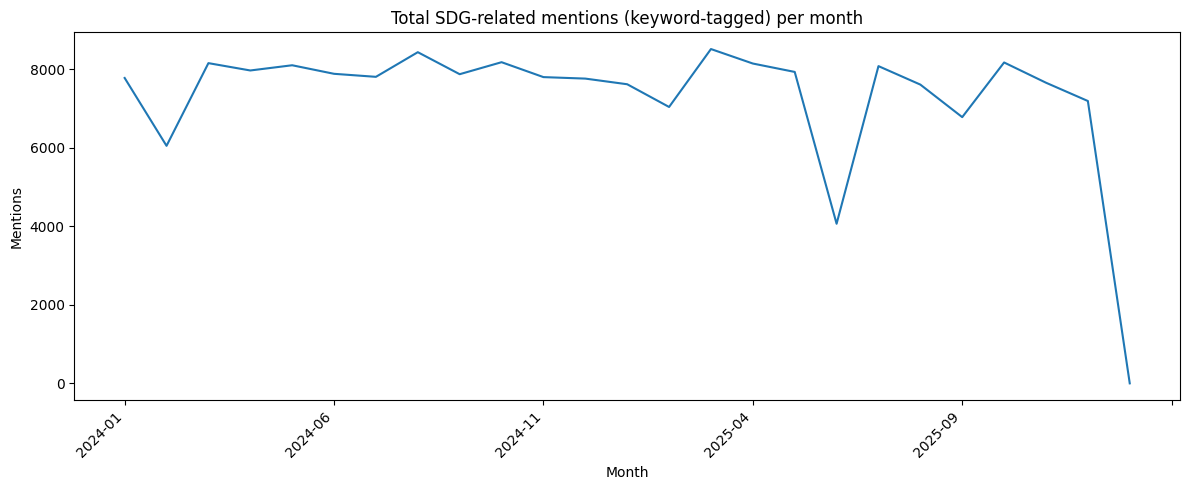

In [24]:
plt.figure(figsize=(12,5))
pivot.sum(axis=1).plot()
plt.title('Total SDG-related mentions (keyword-tagged) per month')
plt.xlabel('Month')
plt.ylabel('Mentions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
out = os.path.join(FIG_DIR, 'sdg_total_mentions_per_month.png')
plt.savefig(out, dpi=200)
out


## 2) SDG distribution by language


In [25]:
lang_sdg = (long.groupby(['lang','sdg']).size()
            .reset_index(name='count')
            .sort_values(['lang','count'], ascending=[True, False]))
lang_sdg.head(10)


,lang,sdg,count
0,afrikaans,SDG17_Partnerships,1
1,afrikaans,SDG1_No_Poverty,1
3,albanian,SDG17_Partnerships,309
4,albanian,SDG3_Good_Health,6
2,albanian,SDG11_Sustainable_Cities,2
5,albanian,SDG7_Clean_Energy,1
6,arabic,SDG17_Partnerships,7
7,arabic,SDG9_Industry_Innovation,1
8,armenian,SDG17_Partnerships,1
9,armenian,SDG7_Clean_Energy,1


'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_by_language_heatmap.png'

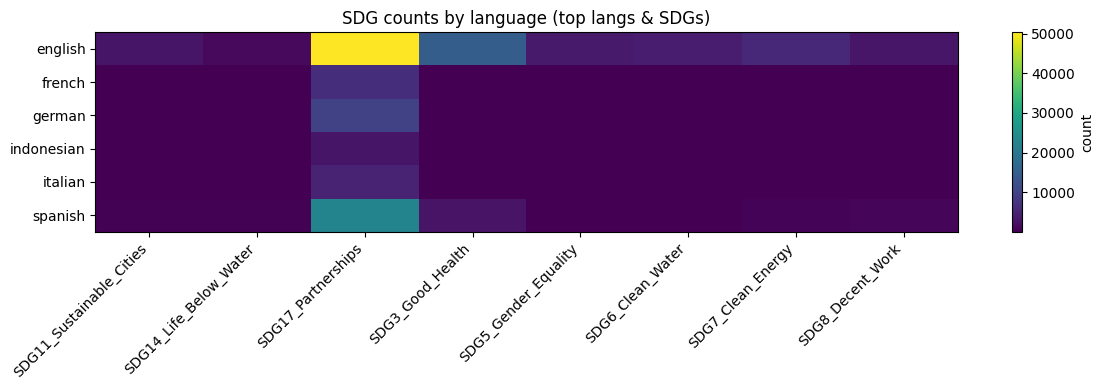

In [26]:
top_langs = lang_sdg.groupby('lang')['count'].sum().sort_values(ascending=False).head(6).index.tolist()
top_sdgs = lang_sdg['sdg'].value_counts().head(8).index.tolist()

sub = lang_sdg[lang_sdg['lang'].isin(top_langs) & lang_sdg['sdg'].isin(top_sdgs)]
heat = sub.pivot(index='lang', columns='sdg', values='count').fillna(0)

plt.figure(figsize=(12,4))
plt.imshow(heat.values, aspect='auto')
plt.yticks(range(len(heat.index)), heat.index)
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha='right')
plt.title('SDG counts by language (top langs & SDGs)')
plt.colorbar(label='count')
plt.tight_layout()
out = os.path.join(FIG_DIR, 'sdg_by_language_heatmap.png')
plt.savefig(out, dpi=200)
out


## 3) Topic modeling (baseline LDA)

We do a quick LDA over text to surface coarse themes. For multilingual data, you may prefer:
- per-language topic models, or
- translation to a pivot language, or
- embedding + clustering.


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

sample = tagged.sample(min(1500, len(tagged)), random_state=42).copy()
texts = sample['text'].fillna('').tolist()

vectorizer = CountVectorizer(max_features=6000, stop_words='english')
X = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=8, random_state=42)
lda.fit(X)

vocab = np.array(vectorizer.get_feature_names_out())

def top_words(topic_idx, n=12):
    w = lda.components_[topic_idx]
    return vocab[np.argsort(w)[-n:]][::-1].tolist()

topics = {f'topic_{i}': top_words(i) for i in range(lda.n_components)}
topics


{'topic_0': ['die',
  'health',
  'funding',
  'vaccine',
  'change',
  'says',
  'years',
  'und',
  'climate',
  'global',
  'trump',
  'young'],
 'topic_1': ['la',
  'en',
  'el',
  'los',
  'que',
  'por',
  'una',
  'se',
  'para',
  'del',
  'más',
  'salud'],
 'topic_2': ['health',
  'united',
  'energy',
  'renewable',
  'kingdom',
  'new',
  'global',
  'pakistan',
  'climate',
  '000',
  'students',
  'china'],
 'topic_3': ['climate',
  'el',
  'change',
  'solar',
  'del',
  'la',
  'los',
  'health',
  'report',
  'new',
  'impact',
  '2024'],
 'topic_4': ['news',
  'new',
  'united',
  'health',
  'kingdom',
  'di',
  'says',
  'county',
  'children',
  'public',
  'water',
  'plans'],
 'topic_5': ['health',
  'und',
  'energy',
  'solar',
  'women',
  'care',
  'trump',
  '2024',
  'public',
  'climate',
  'american',
  'covid'],
 'topic_6': ['la',
  'una',
  'en',
  'energy',
  'climate',
  'del',
  'que',
  'el',
  'al',
  'para',
  'solar',
  'new'],
 'topic_7': ['la',

## 4) Simple SDG ↔ country co-occurrence network

We build an edge list where weight = count of (country, SDG) co-mentions.


In [28]:
edges = (long.groupby(['source_country','sdg']).size()
         .reset_index(name='weight')
         .dropna(subset=['source_country','sdg'])
         .sort_values('weight', ascending=False))
edges.head(10)


,source_country,sdg,weight


In [29]:
out_edges = os.path.join(PROCESSED_DIR, 'sdg_country_edges.csv')
edges.to_csv(out_edges, index=False)
out_edges


'/Users/sergey/code/sdg-multilingual-media-narratives/data/processed/sdg_country_edges.csv'

### Visualization with NetworkX


In [39]:
import pandas as pd
import numpy as np
from IPython.display import display

# если FIG_DIR не задан
if "FIG_DIR" not in globals():
    FIG_DIR = "figs"

fill_rate = long["source_country"].notna().mean()
print(f"country fill-rate in long: {fill_rate:.2%}")

# пересчёт edges (ВАЖНО: делать ПОСЛЕ fill source_country)
edges = (
    long.dropna(subset=["source_country", "sdg"])
        .assign(
            source_country=lambda df: df["source_country"].astype("string").str.strip(),
            sdg=lambda df: df["sdg"].astype("string").str.strip()
        )
        .loc[lambda df: df["source_country"].str.len() > 0]
        .groupby(["source_country", "sdg"])
        .size()
        .reset_index(name="weight")
        .sort_values("weight", ascending=False)
)

print("edges.shape:", edges.shape)
if len(edges) == 0:
    raise ValueError("edges пустой — значит после fill всё ещё нет валидных (country, sdg).")

print("weight stats:")
display(edges["weight"].describe())

print("top edges:")
display(edges.head(15))


country fill-rate in long: 98.33%
edges.shape: (2485, 3)
weight stats:


count     2485.000000
mean        72.304628
std        612.598286
min          1.000000
25%          1.000000
50%          4.000000
75%         15.000000
max      22453.000000
Name: weight, dtype: float64

top edges:


,source_country,sdg,weight
2369,United States,SDG17_Partnerships,22453
2088,Spain,SDG17_Partnerships,9762
2372,United States,SDG3_Good_Health,8378
828,Germany,SDG17_Partnerships,7960
2352,United Kingdom,SDG17_Partnerships,6670
1104,Italy,SDG17_Partnerships,4773
65,Argentina,SDG17_Partnerships,3925
424,Canada,SDG17_Partnerships,3704
1008,India,SDG17_Partnerships,3306
755,France,SDG17_Partnerships,3108


Using MIN_W=2, top rows=180 (from 2485)
G nodes: 92 edges: 180


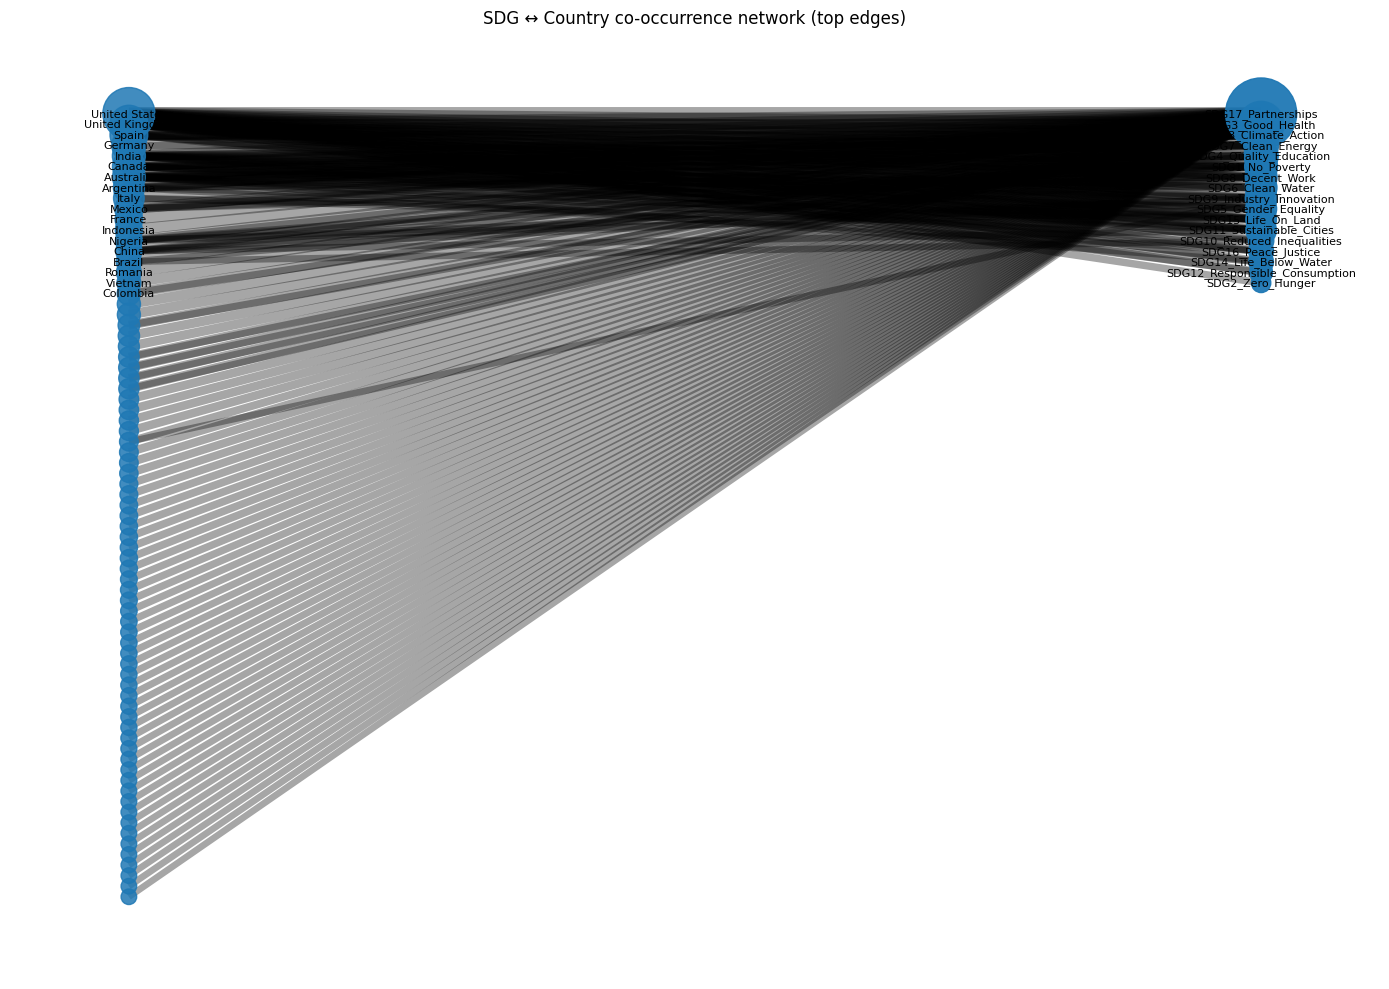

'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_country_network_fixed.png'

In [40]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

os.makedirs(FIG_DIR, exist_ok=True)

# параметры
TOP_EDGES = 180
TOP_COUNTRIES_LABEL = 18

# автопорог: если максимум = 1, то MIN_W=1; иначе можно 2 (или больше)
wmax = int(edges["weight"].max())
MIN_W = 1 if wmax <= 1 else 2

top = edges[edges["weight"] >= MIN_W].head(TOP_EDGES).copy()
print(f"Using MIN_W={MIN_W}, top rows={len(top)} (from {len(edges)})")

# если вдруг всё равно пусто — снимаем фильтр
if len(top) == 0:
    print("⚠️ top пустой, снимаю MIN_W и беру просто TOP_EDGES.")
    top = edges.head(TOP_EDGES).copy()

G = nx.Graph()
for _, r in top.iterrows():
    G.add_edge(f"C:{r['source_country']}", f"S:{r['sdg']}", weight=float(r["weight"]))

print("G nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())
if G.number_of_edges() == 0:
    raise ValueError("Граф всё ещё пустой — значит top реально пустой (проверь edges).")

countries = [n for n in G.nodes() if n.startswith("C:")]
sdgs      = [n for n in G.nodes() if n.startswith("S:")]

strength = dict(G.degree(weight="weight"))

# стабильная бипартидная раскладка: страны слева, SDG справа
pos = {}
for i, n in enumerate(sorted(countries, key=lambda x: strength.get(x, 0), reverse=True)):
    pos[n] = (0.0, -i)
for j, n in enumerate(sorted(sdgs, key=lambda x: strength.get(x, 0), reverse=True)):
    pos[n] = (1.0, -j)

country_sizes = [60 + 6*math.sqrt(strength.get(n, 0)) for n in countries]
sdg_sizes     = [80 + 8*math.sqrt(strength.get(n, 0)) for n in sdgs]

weights = np.array([G[u][v]["weight"] for u, v in G.edges()], dtype=float)
edge_widths = [max(0.6, math.log(w + 1)) for w in weights]

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, nodelist=countries, node_size=country_sizes, alpha=0.85)
nx.draw_networkx_nodes(G, pos, nodelist=sdgs,      node_size=sdg_sizes,     alpha=0.95)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.35)

# подписи: все SDG + топ стран
top_countries = sorted(countries, key=lambda x: strength.get(x, 0), reverse=True)[:TOP_COUNTRIES_LABEL]
label_nodes = set(sdgs) | set(top_countries)
labels = {n: n.split(":", 1)[1] for n in label_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("SDG ↔ Country co-occurrence network (top edges)")
plt.axis("off")
plt.tight_layout()

out = os.path.join(FIG_DIR, "sdg_country_network_fixed.png")
plt.savefig(out, dpi=220)
plt.show()
out


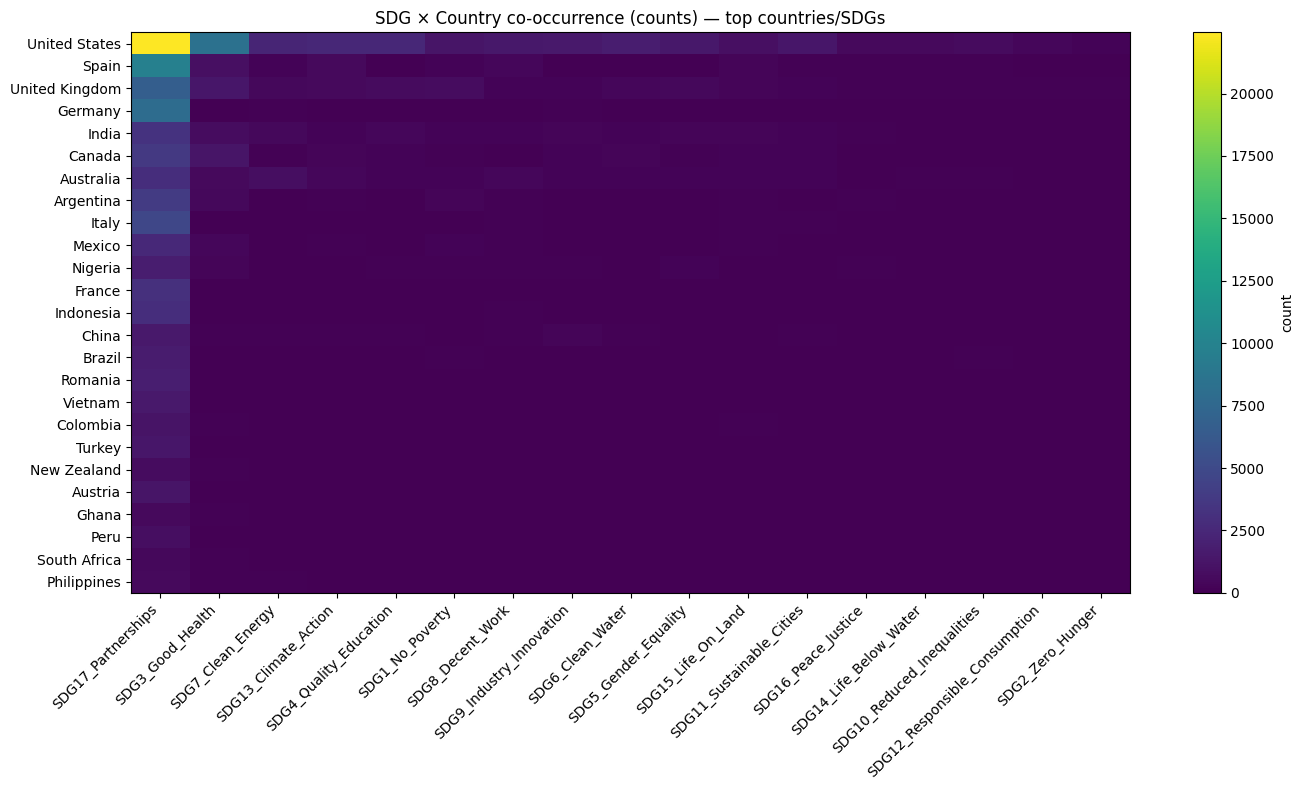

'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_country_heatmap_counts.png'

In [41]:
import os
import matplotlib.pyplot as plt

os.makedirs(FIG_DIR, exist_ok=True)

TOP_C = 25
TOP_S = 17

country_tot = edges.groupby("source_country")["weight"].sum().sort_values(ascending=False)
sdg_tot     = edges.groupby("sdg")["weight"].sum().sort_values(ascending=False)

top_c = country_tot.head(TOP_C).index.tolist()
top_s = sdg_tot.head(TOP_S).index.tolist()

mat = (edges[edges["source_country"].isin(top_c) & edges["sdg"].isin(top_s)]
       .pivot_table(index="source_country", columns="sdg", values="weight", aggfunc="sum", fill_value=0))

mat = mat.loc[mat.sum(axis=1).sort_values(ascending=False).index, top_s]

plt.figure(figsize=(14, 8))
plt.imshow(mat.values, aspect="auto")
plt.yticks(range(len(mat.index)), mat.index)
plt.xticks(range(len(mat.columns)), mat.columns, rotation=45, ha="right")
plt.title("SDG × Country co-occurrence (counts) — top countries/SDGs")
plt.colorbar(label="count")
plt.tight_layout()

out = os.path.join(FIG_DIR, "sdg_country_heatmap_counts.png")
plt.savefig(out, dpi=220)
plt.show()
out


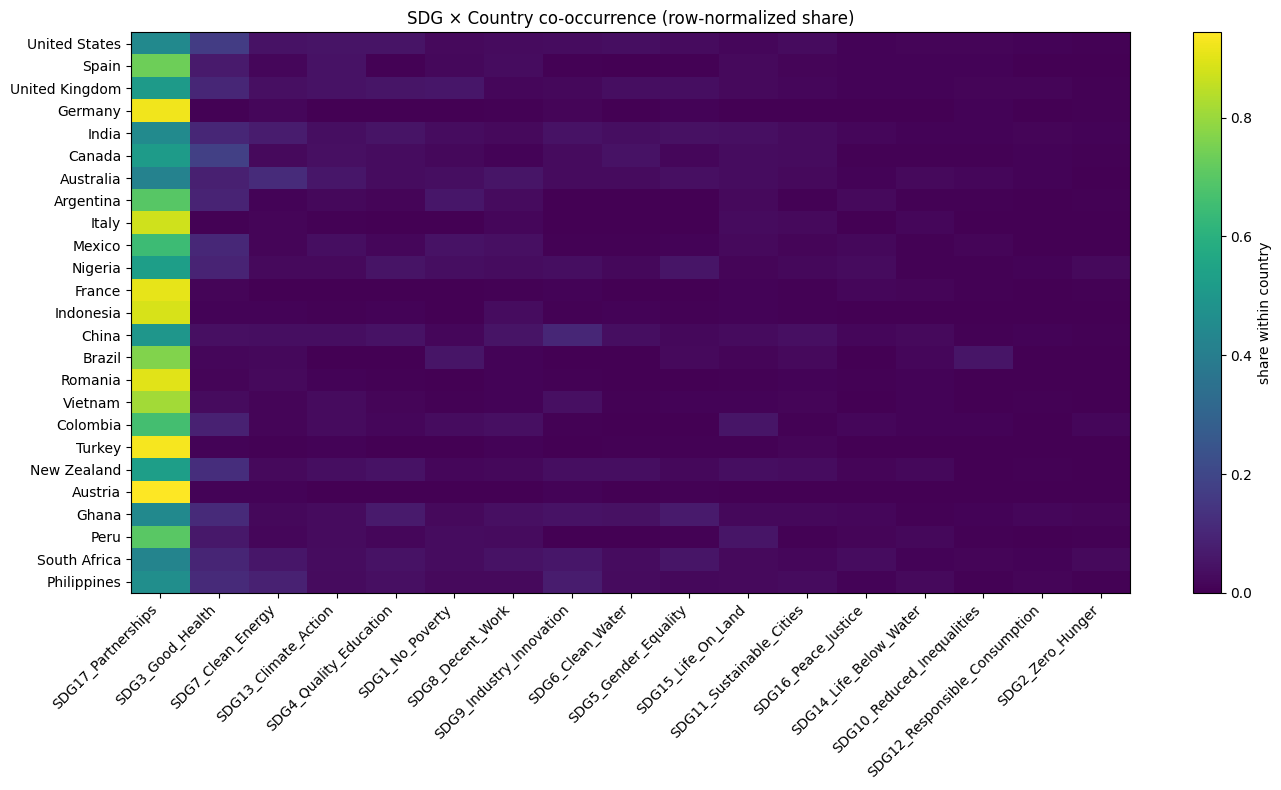

'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_country_heatmap_share.png'

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs(FIG_DIR, exist_ok=True)

mat_share = mat.div(mat.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

plt.figure(figsize=(14, 8))
plt.imshow(mat_share.values, aspect="auto")
plt.yticks(range(len(mat_share.index)), mat_share.index)
plt.xticks(range(len(mat_share.columns)), mat_share.columns, rotation=45, ha="right")
plt.title("SDG × Country co-occurrence (row-normalized share)")
plt.colorbar(label="share within country")
plt.tight_layout()

out = os.path.join(FIG_DIR, "sdg_country_heatmap_share.png")
plt.savefig(out, dpi=220)
plt.show()
out


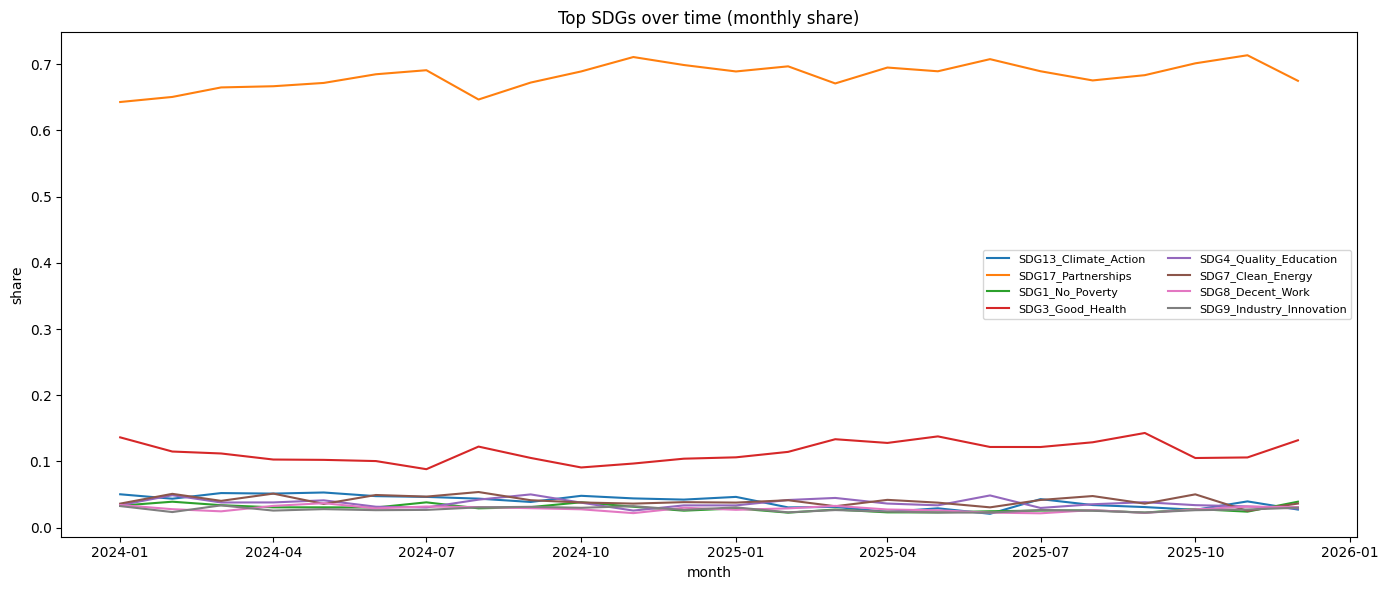

'/Users/sergey/code/sdg-multilingual-media-narratives/figures/sdg_monthly_share_top.png'

In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.makedirs(FIG_DIR, exist_ok=True)

df = long.dropna(subset=["sdg", "month"]).copy()
df["sdg"] = df["sdg"].astype("string")

# нормализуем month в порядок
m = df["month"].astype("string")
# если month уже "YYYY-MM" — ок; если бывает мусор, отфильтруем
m_ok = m.str.match(r"^\d{4}-\d{2}$", na=False)
df = df[m_ok].copy()
df["month"] = pd.PeriodIndex(df["month"], freq="M").to_timestamp()

# топ SDG по суммарному объёму
top_sdgs = (df["sdg"].value_counts().head(8).index.tolist())

ts = (df[df["sdg"].isin(top_sdgs)]
      .groupby(["month", "sdg"])
      .size()
      .reset_index(name="n"))

pivot = ts.pivot(index="month", columns="sdg", values="n").fillna(0)
share = pivot.div(pivot.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

plt.figure(figsize=(14, 6))
for c in share.columns:
    plt.plot(share.index, share[c], label=c)
plt.title("Top SDGs over time (monthly share)")
plt.xlabel("month")
plt.ylabel("share")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()

out = os.path.join(FIG_DIR, "sdg_monthly_share_top.png")
plt.savefig(out, dpi=220)
plt.show()
out
